In [18]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Static Variables

In [19]:
line = "15"

### Reading Data

In [20]:
schedule = pd.read_csv("bus_data/dublinbus_scheduledData2013csv.csv", low_memory=False, encoding="ISO-8859-1")


In [21]:
# schedule.iloc[135418:135425]

### Cleaning Data

In [22]:
# dropping rows with missing values 
schedule = schedule.dropna()

In [23]:
# Extracting StopID from stop_id

def get_stop(string):
    var = string[-4:]
    return var

schedule["StopID"] = schedule['stop_id'].apply(lambda x: get_stop(x))

In [24]:
# Extracting LineID from trip_id

schedule["LineID"] = schedule["trip_id"].str.extract('\-(.*?)\-')

/Users/danieljordan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  app.launch_new_instance()


In [25]:
schedule.head()

,trip_id,arrival_time,departure_time,stop_id,Name without locality,Name,Lat,Long,stop_sequence,stop_headsign,shape_dist_traveled,StopID,LineID
0,1.1598.0-33A-b12-1.451.I,16:15:00,16:15:00,8240DB003813,Footbridge,Skerries Road,53.591377,-6.156176,1,Swords,0.000000,3813,33A
1,1.1598.0-33A-b12-1.451.I,16:15:39,16:15:39,8240DB003814,Barnageeragh Road,Balbriggan Rd,53.585544,-6.148605,2,Swords,827.070328,3814,33A
2,1.1598.0-33A-b12-1.451.I,16:17:11,16:17:11,8240DB003815,Barnageeragh Road,North Cliff Heights,53.581935,-6.125247,3,Swords,2746.649492,3815,33A
3,1.1598.0-33A-b12-1.451.I,16:17:22,16:17:22,8240DB003816,Mourne Drive,North Cliff Heights,53.580471,-6.127622,4,Swords,2973.900755,3816,33A
4,1.1598.0-33A-b12-1.451.I,16:17:44,16:17:44,8240DB003566,Selskar Court,Town Parks Rd,53.578067,-6.125055,5,Swords,3447.155571,3566,33A


### Getting Stops From Schedule 1

In [26]:
schedule.drop_duplicates(subset="StopID", inplace="True")

In [27]:
stops_1 = schedule[["StopID", "Name without locality", "Name", "Lat", "Long"]]

In [28]:
# 4693 before dropping NaN rows - 4697 after. WTF? Whatever. 

stops_1.shape

(4693, 5)

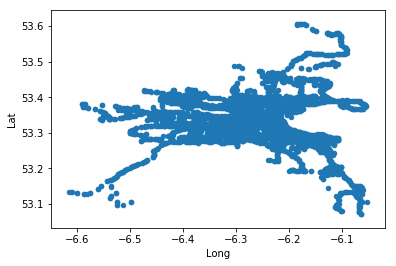

In [29]:
locations = stops_1[["Long", "Lat"]]
locations.plot.scatter(x="Long", y="Lat")

In [30]:
# # filtering out one weird row (index: 135419)

# stops1 = stops_1[stops_1.StopID.apply(lambda x: str(x).isdigit())]

# # df[df['entrytype'].apply(lambda x: str(x).isdigit())]

# stops1 = stops1[stops1.StopID.str.contains(":") == False]


### Saving to CSV

In [31]:
stops_1.to_csv("bus_data/static_data/stops_all.csv")

### Getting Stops From Schedule 2 (Doesn't work properly)

In [15]:
# Number of unique LineIDs 

stops = schedule["StopID"].unique()

print(len(stops))

4693


In [16]:
stops_df = schedule["StopID"]
stops_df = stops_df.drop_duplicates()
stops_df = stops_df.reset_index()
stops_df = stops_df.drop('index', axis=1)

In [17]:
# static_stops = pd.merge(stops_df, schedule, on='StopID')

# pd.merge(order, loc_df, on='StopID')